# Progetto DL24: YesWeKAN - Introduzione sulle KAN

💡 Durante il periodo di scelta del progetto del corso di Deep Learning, il nostro collega Giovanni Zedda ci presenta un paper che si è subito sembrato interessante: [KAN: Kolmogorov–Arnold Networks](https://arxiv.org/pdf/2404.19756). Parla di una rete neurale con un concetto completamente diverso dalla classica architettura MLP, non ha una matrice di pesi con cui fare combinazioni lineari, ma ha una **matrice di funzioni**, di cui si addestrano i coefficienti.

📊 I risultati del paper sembrano promettenti: in conclusione le reti KAN sono **più accurate** e **più spiegabili** delle reti MLP, così abbiamo scelto per il nostro progetto di approfondire l'argomento.

In questo notebook vedremo come è avvenuta la scelta del dataset, e come funzionano le KAN e la loro implementazione, per poi spostarci nel codice dove faremo un esempio di utilizzo delle KAN.

## Scelta del dataset

💱 Visto che il **cambio radicale** nell'architettura avviene al **livello degli archi** tra input e output di un qualsiasi livello, è possibile definire tutti i principali tipi di livelli visti durante il corso: non solo i livelli densamente connessi, ma anche convolutivi, ricorrenti, e perfino transformer. Tuttavia in questo progetto, dovendo implementare autonomamente questo nuovo tipo di rete, abbiamo optato per usare dei **livelli densamente connessi**.

🩺 Per la scelta del dataset, vista la maggiore spiegabilità delle reti KAN, abbiamo scelto un dataset in **campo medico**, in cui la spiegabilità e la trasperanza algoritmica sono fattori determinanti non solo per il personale medico, che ha -anche- il compito di valutare le decisioni della rete, ma anche per i pazienti, in modo che possano prendere coscienza dei motivi dietro le scelte mediche.

🏥 Il dataset che abbiamo scelto, dopo aver guardato le opzioni disponibili su [Kaggle](https://www.kaggle.com/), è [Hospital Length of Stay Dataset Microsoft](https://www.kaggle.com/datasets/aayushchou/hospital-length-of-stay-dataset-microsoft). Qui il task è di **regressione**, e consiste nello stimare i giorni di ricovero di un paziente, conoscendo diversi dati personali e medici di quest'ultimo. 

Analizzeremo il dataset nel notebook **Analisi, confronto e spiegabilità**.

## Cosa sono le KAN

📋 Prima di partire con l'implementazione dei modelli e quindi delle KAN, dobbiamo capire come funzionano e quali sono le caratteristiche fondamentali di queste. Per fare ciò la comprensione del paper da cui abbiamo preso ispirazione per il progetto ci ha dato una grossa mano, e qui riportiamo i punti salienti.

📈 Le **Kolmogorov Arnold Network** (KAN) sono un'alternativa alle reti multi-layer perceptron (MLP). Mentre le MLP hanno le funzioni di attivazione fissate sui nodi e utilizzano pesi lineari, le KAN hanno le funzioni di **attivazione non lineari addestrabili sugli archi**, e usano parametri definiti come funzioni univariate, spesso funzioni **spline**.

Mentre le MLP sono ispirate al Teorema dell'Approssimazione Universale, le KAN sono ispirate al **Teorema di Rappresentazione di Kolmogorov-Arnold**, il quale afferma che qualsiasi funzione continua multivariata può essere rappresentata come somma di funzioni di una sola variabile e un numero finito di funzioni.

Le KAN possono essere visualizzate in modo intuitivo, poiché le funzioni di attivazione sugli archi sono **facilmente interpretabili e analizzabili**. Questo aspetto le rende più interpretabili e spiegabili, anche se a parità di parametri sono **più costose da addestrare** e memorizzare rispetto alle MLP. Tuttavia, le KAN più piccole possono essere **più accurate e efficienti** nei parametri.

### Spline

Una spline è una funzione composta da segmenti polinomiali definiti su intervalli diversi, che si uniscono in modo liscio. Ciò significa che i polinomi che formano la spline si connettono in punti specifici chiamati nodi, garantendo continuità e derivate continue fino a un certo ordine. Le spine di un ordine $n$ si definiscono ricorsivamente da quelle di ordine $0$.

Data una funzione, un numero di intervalli e il grado, le spline approssimano tale funzione. 

È possibile aumentare il numero di intervalli, quindi aumentando la precisione dell'approssimazione globalmente, ed è possibile aumentare il loro grado per aumentare la precisione dell'approssimazione localmente (spline di grado 0 approssimeranno la funzione con delle rette orizzontali, spline di grado 1 con rette oblique, di grado 2 con parabole, ecc...).

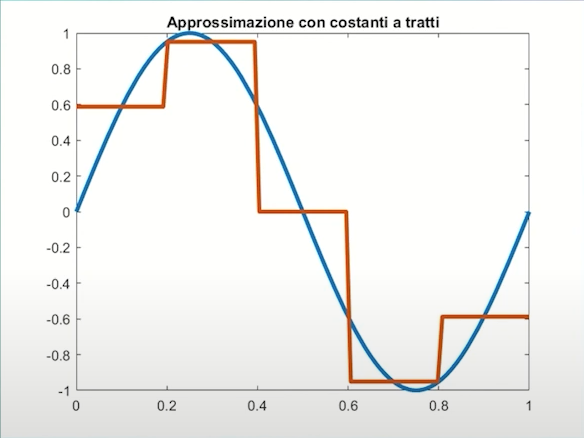 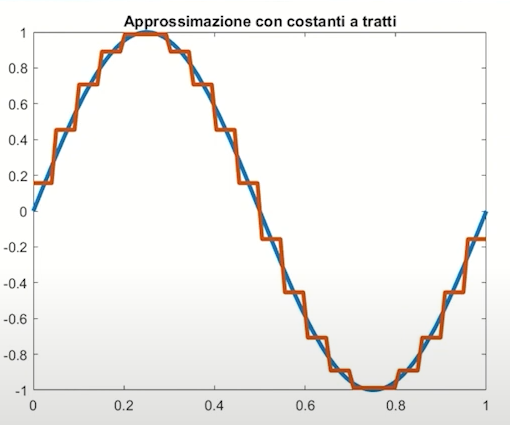 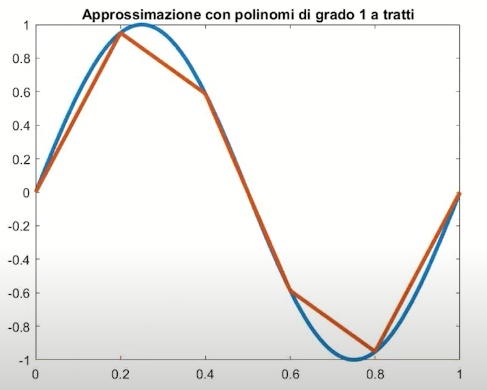

### Accuratezza

Le KAN sanno essere più accurate delle MLP. Le spline offrono un maggiore potere espressivo, espressività che le MLP per raggiungerlo devono essere molto più grandi.

Le KAN grazie a questo raggiungono la stessa accuratezza delle MLP addestrandosi con molti meno parametri (quindi una rete molto più compatta), ma più complicati da addestrare (che richiedono più tempo e complessità nella fase di backpropagation). La maggiore espressività porta però le KAN ad essere più scalabili, quindi ad aumentare la propria accuratezza più velocemente delle MLP, e questo porta ad avere prestazioni migliori su un numero di epoche minore delle MLP; il confronto quindi sarà tra una rete KAN con un maggiore tempo di addestramento per epoca contro una rete MLP con un maggior numero di epoche, in cui la rete KAN è più scalabile.

Nel confronto dobbiamo però anche considerare che le reti KAN, venendo studiate in questo momento, non sono ottimizzate tanto quanto le reti MLP, e questo sicuramente porta ad uno svantaggio competitivo nei confronti tra le due.

### Interpretabilità

Le KAN riescono ad essere più interpretabili per loro natura. Il teorema di Kolmogorov-Arnold, su cui sono basate, offre una struttura matematica chiara per essere visualizzata e capita. Inoltre la capacità di poter visualizzare le funzioni di attivazione direttamente nell'arco permette una più facile interpretabilità rispetto all'architettura MLP.

Le KAN inoltre, attraverso le spline, riescono ad imparare funzioni comuni facilmente, come moltiplicazione, divisione, e simili. Grazie a questo, le KAN durante l'addestramento possono ottenere alcune delle funzioni spline addestrabili che approssimano sempre di più una funzione nota (quale ad esempio una funzione esponenziale). È dunque possibile impostare i coefficienti di tale spline direttamente per approssimare il più fedelmente possibile tale funzione e controllare le sue performance. Nel caso in cui queste migliorino, si è trovato una funzione simbolica per quell'arco.
Quando questo avviene su tutti gli archi attivi della rete (se il datatset lo concede), si è arrivati ad avere la formula simbolica per eseguire il task algoritmicamente.

## Implementazione delle KAN

### Implementazione del paper

Gli autori del paper sopra citato hanno implementato i loro modelli e li hanno [messi a disposizione](https://github.com/KindXiaoming/pykan), ma li hanno scritti usando il framework di PyTorch; data la differenza rispetto a Tensorflow che abbiamo usato durante il corso, abbiamo scelto di implementare un livello __Dense KAN__ autonomamente sul framework di Tensorflow, anche per prendere confidenza con i concetti che ci sono dietro e che analizzeremo a breve.

Fortunatamente non siamo partiti completamente da zero, abbiamo infatti trovato [questa libreria](https://github.com/ZPZhou-lab/tfkan), che sembra implementi i concetti che ci interessano. Nella realtà però, dopo averla provata, ci siamo resi conto che non era perfettamente funzionante, probabilmente a causa del fatto che sia stata sfruttata con un ambiente obsoleto. La abbiamo così analizzata, e abbiamo rimosso le funzionalità che non erano più utilizzabili, abbiamo ottimizzato qualche passaggio negli algoritmi di calcolo, e inserito diversi commenti per 

### Implementazione nel nostro progetto


In questo notebook vedremo nel dettaglio come funziona una KAN internamente, con un record d'esempio, andremo a visualizzare il modo in cui le **spline** vengono modellate in fase di addestramento e come vengono composte in fase di predizione.

Per prima cosa importiamo le librerie necessarie al notebook

In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import preprocess_dataset as ut
from tfkan import DenseKAN

In [2]:
# Valore del seme causale
seed_value = 0

# Impostazione dei semi casuali per os, random, numpy e tensorflow
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

Prepariamo il dataset per l'addestramento e selezioniamo un record di esempio

In [3]:
x_train = pd.read_csv("datasets/x_train.csv")   # Caricamento del dataset
y_train = pd.read_csv("datasets/y_train.csv")

ut.standardize(x_train)                         # Standardizzazione
x_train = x_train.to_numpy()[:, 1:-1]
y_train = y_train.to_numpy()[:, -1]

x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)   # Conversione a tensore
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

my_record = x_train[8]                                      # Selezione del record di esempio

Un livello della KAN può essere formalizzato come una matrice di funzioni

$$
\Phi_{l} = 
\begin{bmatrix}
\phi_{11} & \phi_{12} & \cdots & \phi_{1n} \\
\phi_{21} & \phi_{22} & \cdots & \phi_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
\phi_{m1} & \phi_{m2} & \cdots & \phi_{mn}
\end{bmatrix}
$$
In cui ogni funzione $\phi$ è definita come

$$
\phi(x) = w_bb(x) + w_s\sum_i{c_iB_i(x)}
$$

L'output n-esimo di una KAN a un livello con un imput di dimensione m è dato dalla formula
$$
KAN(x)_n = \sum_{i_{0}=1}^{m}\phi_{n,i_0}(x_{i_0})
$$

A questo punto possiamo definire l'architettura del modello, compilarlo ed addestrarlo.

Faremo un breve addestramento in quanto ora l'obiettivo non è quello di ottimizzare le prestazioni ma piuttosto quello di illustrare un processo.

In [4]:
input_dim = x_train.shape[1]
layer1_dim = 4
layer2_dim = 1

# Architettura del modello
model = tf.keras.models.Sequential([
    DenseKAN(layer1_dim, grid_range=(-2,2), grid_size=20),
    DenseKAN(layer2_dim, grid_range=(-2,2), grid_size=20)
])

# Costruzione, compilazione e addestramento del modello
model.build(input_shape=(None, input_dim))
model.summary()
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.fit(x_train, y_train, epochs=10, batch_size=64)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_kan (DenseKAN)            │ (None, 4)              │         1,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_kan_1 (DenseKAN)          │ (None, 1)              │            72 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,728 (6.75 KB)

 Trainable params: 1,728 (6.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 12.4305 - mse: 12.4305
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.7630 - mse: 0.7630
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.5734 - mse: 0.5734
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.5175 - mse: 0.5175
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4953 - mse: 0.4953
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.4829 - mse: 0.4829
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.4744 - mse: 0.4744
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.4685 - mse: 0.4685
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4642 - mse: 0.4642
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4606 - mse: 0.4606


Vediamo ora come è avvenuto il processamento del nostro record nel primo layer del modello.

Per farlo estraiamo le spline del layer con il metodo **get_spline_list()**. Questo metodo restituisce la matrice delle spline di dimensione input_dim * layer1_dim, nel nostro caso 25 * 4 = 100.

Per rappresentare graficamente le spline del livello usiamo una matrice grafica 4 x 25 con un grafico di spline in ogni cella; per ogni riga, ognuna delle 25 spline prenderà in input l'i-esimo attributo del record d'esempio (qui segnato con una linea rossa) e restituirà in output l'immagine di quell' attributo (qui segnato con una linea verde).

Il vettore passato al livello successivo (di dimensione layer1_dim) avrà come i-esimo valore la somma delle immagini rappresentate nella i-esima riga del livello precedente.

In questa cella calcoliamo per ognuna delle $n$ unità in output $$l_n = \sum_{i_{0}=1}^{25}{\phi_{n,i_0}(x_{i_0})}$$

Avremo infine i quattro valori restituiti dal livello

Output del primo livello: [ 0.57920341  0.23513184 -0.83601147 10.71635091]


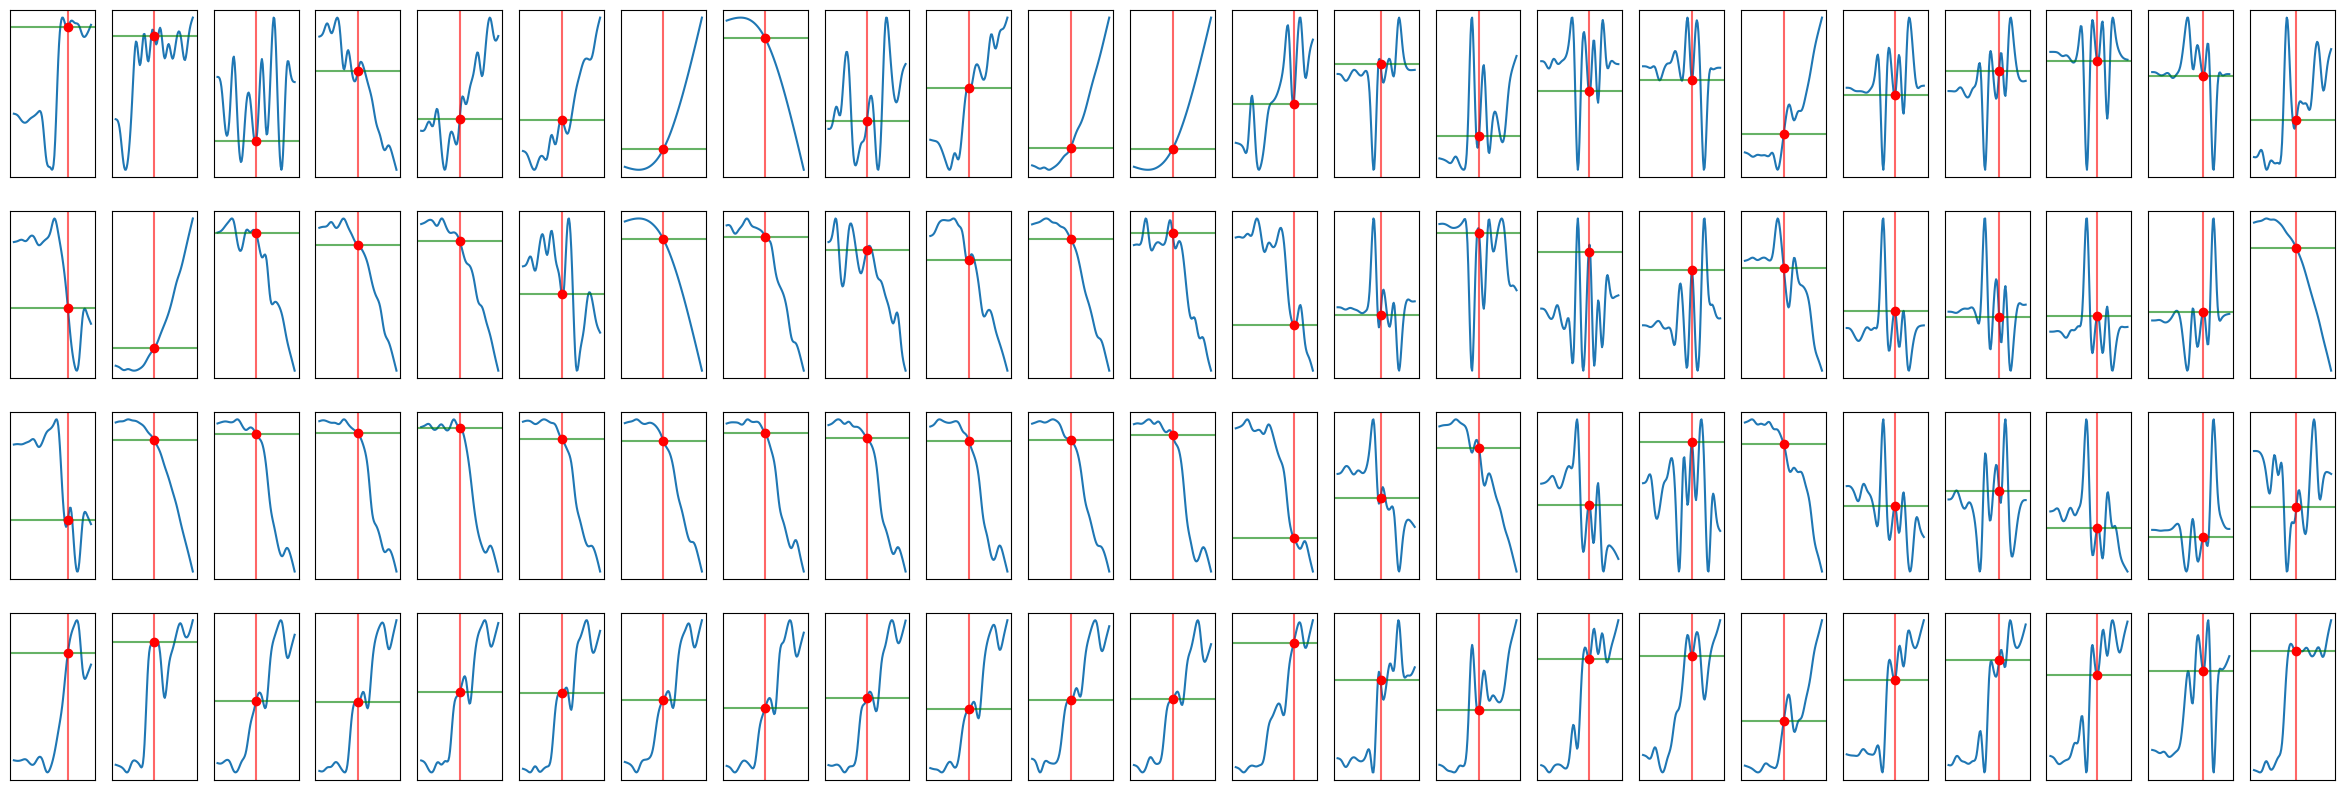

In [5]:
fig, axes = plt.subplots(layer1_dim, input_dim, figsize=(30, 10))   # Preparazione dell'area grafica

spline_list = model.layers[0].get_spline_list()                     # Estrazione delle spline del livello

layer1_output = np.zeros(layer1_dim)    # Output del livello (input del livello successivo)

# Stampa delle spline del livello con le linee che rappresentano attributi e immagini del record
for i in range(layer1_dim):
    for j in range(input_dim):
        xx = np.linspace(-2, 2, 100)
        yy = spline_list[j][i](tf.convert_to_tensor(xx, dtype=tf.float32))
        axes[i][j].plot(xx, yy)
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
        axes[i][j].axvline(x=my_record[j], color='red', alpha=0.6)
        axes[i][j].axhline(y=spline_list[j][i](my_record[j]), color='green', alpha=0.6)
        axes[i][j].plot(my_record[j], spline_list[j][i](my_record[j]), 'ro')
        layer1_output[i] += spline_list[j][i](my_record[j])

print(f"Output del primo livello: {layer1_output}")

plt.show()

Passando ora al secondo livello, che ha dimensione 4 * 1 = 4, ripetiamo il processo e vediamo il valore che la rete restituisce in output dato dalla formula

$$output = \sum_{i_{1}=1}^{4}{\phi_{i_1}(l_{i_1})}$$

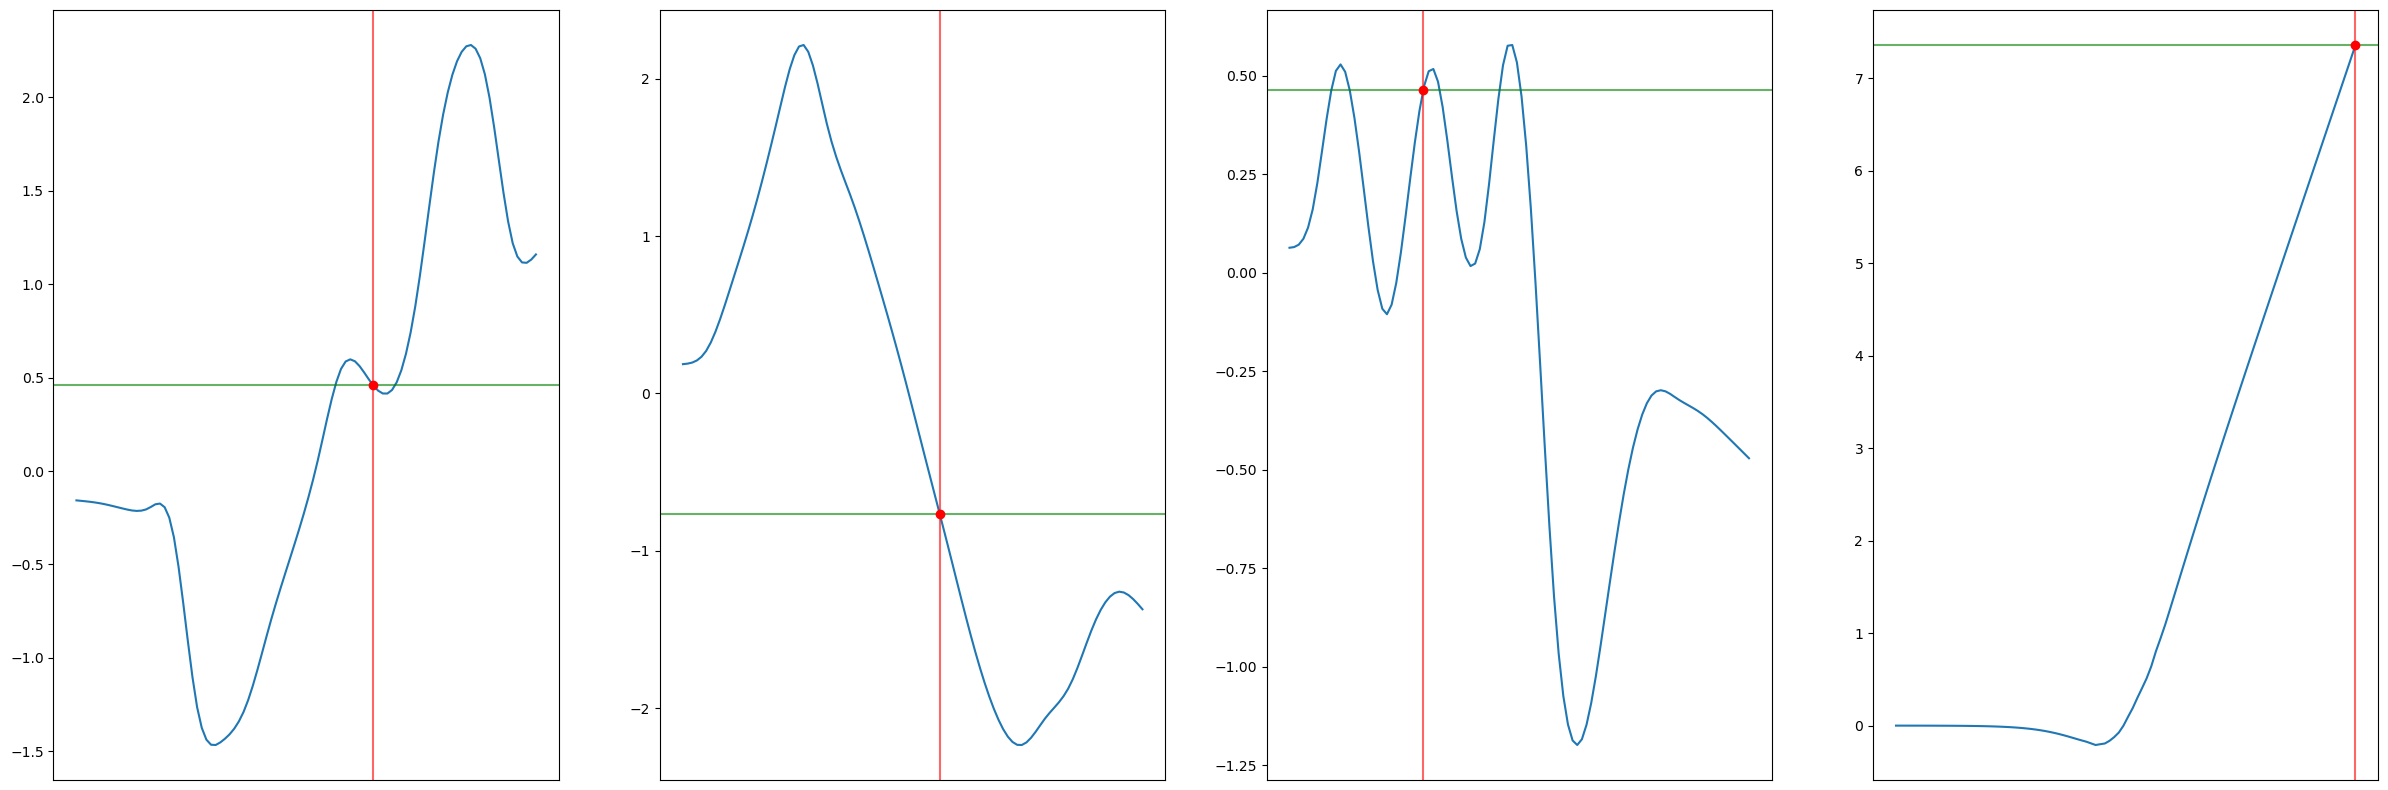

Predizione della rete: 7.518395096063614, label reale: 8.0


In [11]:
fig, axes = plt.subplots(layer2_dim, layer1_dim, figsize=(30, 10), squeeze=False)

spline_list_1 = model.layers[1].get_spline_list()

layer2_output = 0

for i in range(layer2_dim):
    for j in range(layer1_dim):

        xx = np.linspace(-2, 2, 100) if -2 <= layer1_output[j] <= 2 else np.linspace(-abs(layer1_output[j]), abs(layer1_output[j]), 100)
        yy = spline_list_1[j][i](tf.convert_to_tensor(xx, dtype=tf.float32))
        axes[i][j].plot(xx, yy)
        axes[i][j].set_xticks([])
        axes[i][j].axvline(x=layer1_output[j], color='red', alpha=0.6)
        axes[i][j].axhline(y=spline_list_1[j][i](layer1_output[j]), color='green', alpha=0.6)
        axes[i][j].plot(layer1_output[j], spline_list_1[j][i](layer1_output[j]), 'ro')
        layer2_output += spline_list_1[j][i](layer1_output[j])

plt.show()

print(f"Predizione della rete: {layer2_output}, label reale: {y_train[8]}")